In [21]:
# usings

using Pkg; Pkg.activate(".")
using Dates
# using Regex
using Interpolations
using Printf
using PyPlot

# general PSL DAS readers
include("./readers.jl")
using .NoaaDas
using .DasFps

# data = """5958832 r14.932;a73;q100
# 5959238 r15.297;a29;q87"""

  Activating project at `~/Projects/ASTRAL/mast`


In [29]:
m2n(x) = ismissing(x) ? NaN : x

# interpolator
"convert DateTime to a Number (milliseconds) delta relative to offset"
itime(dt, offst=DateTime(2024,4,1)) = Dates.value(dt - offst)

"linear interpolation function with DateTime coordinate"
function interpit(dt::AbstractVector{DateTime}, x::AbstractVector{<:Number})
    itp_core = interpolate( (itime.(dt),), x, Gridded(Linear()) )
    itp(dt) = itp_core( itime(dt) )
    return itp
end

interpit

In [23]:
baseyear = 2024

#=
function parse_lsr_line(line, 
    line = """5958832 r14.932;a73;q100""
    lsr_regex=r"^([\d]{2})([\d]{2})([\d]{3}) r([\d\.]+);a([\d]{2});q([\d]{2,3})" )
    
    M = match(lsr_regex, line).captures
    minut, secnd, millisecnd, A, Q = parse.(Int32, M[[1:3; 5:6]])
    R = parse.(Float32, M[4])
    minut, secnd, millisecnd, R, A, Q
end
=#

function read_lsr_dict( pathfilenames; 
    nheader=1, ncol=3, baseyear=2024,
    nrows=sum( countlines.(pathfilenames) .- nheader ),
    lsrkeys = [:time, :R, :A, :Q],
    lsr_regex=r"^([\d]{2})([\d]{2})([\d]{3}) r([\d\.]+);a([\d]{2});q([\d]{2,3})" )
    
    psldt = Vector{DateTime}(undef, nrows)
    R = Vector{Float32}(undef, nrows)
    A = Vector{Int32}(undef, nrows)
    Q = Vector{Int32}(undef, nrows)

    nl = 0
    # make even one file iterable
    p = pathfilenames isa Vector ? pathfilenames : Ref(pathfilenames)
    for f in p
        # find hour from the filename
        shortfilename = last(splitpath(f))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])
        open(f) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                M = match(lsr_regex, line)
                if !isnothing(M) && !isempty(M)
                    nl += 1
                    minut, secnd, millisecnd, A[nl], Q[nl] = parse.(Int32, M.captures[[1:3; 5:6]])
                    R[nl] = parse.(Float32, M.captures[4])
                    psldt[nl] = psldatetime(basedt, hr, minut, secnd, millisecnd)
                end
            end
        end
    end
    # return truncated data in dictionary
    D = NoaaDas.das_dict(lsrkeys, psldt[1:nl], [R[1:nl] A[1:nl] Q[1:nl]])
end


read_lsr_dict (generic function with 1 method)

In [24]:
dt = today()-Day(1)
Lsr = read_lsr_dict(get_das_pathfiles("lsr", dt))

Dict{Symbol, Any} with 4 entries:
  :R    => Float32[14.132, 14.161, 14.201, 14.233, 14.261, 14.307, 14.393, 14.4…
  :A    => Float32[44.0, 41.0, 48.0, 44.0, 40.0, 29.0, 29.0, 32.0, 30.0, 34.0  …
  :Q    => Float32[84.0, 100.0, 100.0, 100.0, 100.0, 90.0, 85.0, 100.0, 100.0, …
  :time => [DateTime("2024-05-26T00:00:00.609"), DateTime("2024-05-26T00:00:00.…

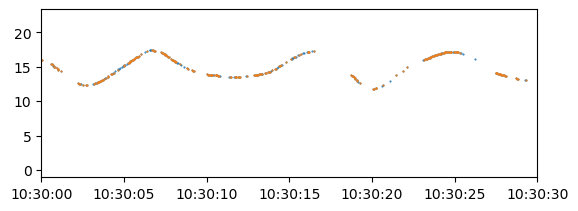

(19869.4375, 19869.437847222223)

In [25]:
ii = (Lsr[:Q] .> 80) .& (Lsr[:R] .> sqrt.(Lsr[:A]))
clf(); subplot(2,1,1)
# plot(Lsr[:time][ii], Lsr[:Q][ii], linestyle="none", marker=".")
# plot(Lsr[:time][ii], Lsr[:A][ii], linestyle="none", marker=".", markersize=1)
ii = (Lsr[:Q] .> 50) .& (Lsr[:R] .> sqrt.(Lsr[:A]))
plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
# ii = (Lsr[:R] .> sqrt.(Lsr[:A]))
# plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
ii = (Lsr[:Q] .>= 80)
plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,30,30)])

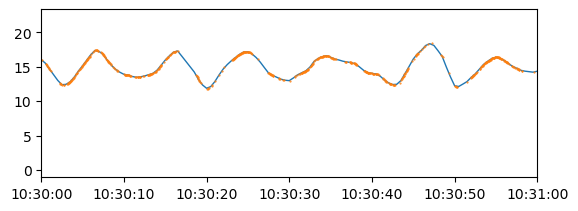

(19869.4375, 19869.438194444443)

In [26]:
ii = (Lsr[:Q] .> 50)
itplsr = interpit(Lsr[:time][ii], Lsr[:R][ii])
cdt = DateTime(2024,5,26,0,0,5):Millisecond(500):DateTime(2024,5,26,23,59,55)
# take care not to get a BoundsError!
# ilsr = itplsr(cdt)

clf(); subplot(2,1,1)
plot(cdt, itplsr.(cdt), linewidth=1)
plot(Lsr[:time][ii], Lsr[:R][ii], linestyle="none", marker=".", markersize=1)
xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
# 2 Hz, and interpolation look great

In [49]:
# read fast pressure
Fp0 = read_fps_dict(get_das_pathfiles("fps0", dt), [:time, :press]; ncolumn=1)
Fp2 = read_fps_dict(get_das_pathfiles("fps2", dt), [:time, :press]; ncolumn=1)
function filtsort(f, (x,y))
    sp = sortperm(x)
    xx, yy = filter(f, (x[sp], y[sp]))
end
f(t,p) = (    isfinite(t) && !ismissing(t) 
           && isfinite(p) && !ismissing(p) 
           && (p .< 10_000) )
(fp0t, fp0p) = filtsort(f, (Fp0[:time], Fp0[:press]))
(fp2t, fp2p) = filtsort(f, (Fp2[:time], Fp2[:press]))
# itpfp0 = interpit(Fp0[:time][ii], m2n.(Fp0[:press][ii]))
# ii = unique(findall(Fp2[:press] .< 10_000))
# itpfp2 = interpit(Fp2[:time][ii], m2n.(Fp2[:press][ii]))

LoadError: MethodError: no method matching f(::Vector{DateTime})

[0mClosest candidates are:
[0m  f(::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[49]:8[24m[39m


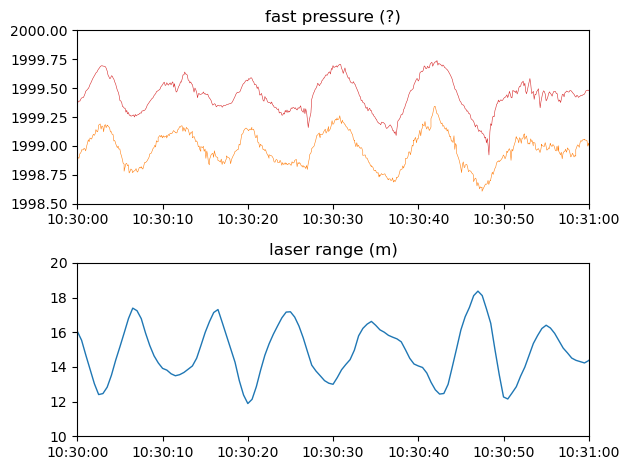

In [69]:

clf()
subplot(2,1,1)
ii = Fp0[:press] .> 10_000
plot(Fp0[:time][ii], Fp0[:press][ii].-9e3, linewidth=0.4)
plot(Fp0[:time][.!ii], Fp0[:press][.!ii], linewidth=0.4)
ii = Fp2[:press] .> 10_000
plot(Fp2[:time][ii], Fp2[:press][ii].-9e3, linewidth=0.4)
plot(Fp2[:time][.!ii], Fp2[:press][.!ii], linewidth=0.4)
xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
ylim([1998.5, 2000])
title("fast pressure (?)")

subplot(2,1,2)
plot(cdt, itplsr.(cdt), linewidth=1)
xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
ylim([10, 20])
title("laser range (m)")

tight_layout()

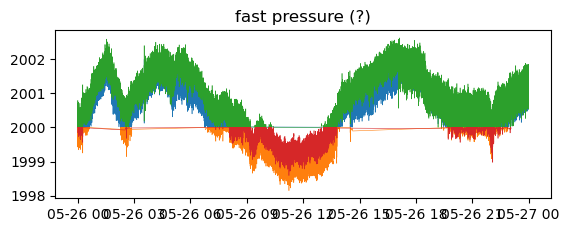

PyObject Text(0.5, 1.0, 'fast pressure (?)')

In [70]:
clf()
subplot(2,1,1)
ii = Fp0[:press] .> 10_000
plot(Fp0[:time][ii], Fp0[:press][ii].-9e3, linewidth=0.4)
plot(Fp0[:time][.!ii], Fp0[:press][.!ii], linewidth=0.4)
ii = Fp2[:press] .> 10_000
plot(Fp2[:time][ii], Fp2[:press][ii].-9e3, linewidth=0.4)
plot(Fp2[:time][.!ii], Fp2[:press][.!ii], linewidth=0.4)
# xlim([DateTime(2024,5,26,10,30), DateTime(2024,5,26,10,31)])
# ylim([1998.5, 2000])
title("fast pressure (?)")